In [13]:
!pip install tqdm

In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score

from tqdm import tqdm

In [15]:
df = pd.read_csv('C:\\Users\\Muhammad Elbaklishy\\Downloads\\Bank.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [16]:
df = df[['age', 'job', 'marital', 'education', 'balance', 'housing',
         'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
         'previous', 'poutcome', 'y' ]]
df.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5
month,may,may,may,may,may
duration,261,151,76,92,198


In [17]:
numerical_vars = df.select_dtypes(include=['int64', 'float64'])
categorical_vars = df.select_dtypes(include=['object'])

print("Numerical Variables:")
numerical = list(numerical_vars.columns)
print(numerical)

print("\nCategorical Variables:")
categorical = list(categorical_vars.columns)
print(categorical)

Numerical Variables:
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Categorical Variables:
['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome', 'y']


In [18]:
df.y = (df.y == 'yes').astype(int)
df.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [19]:
# Split data to (train: 80% , val: 20% , test: 20%)
# Split data to df_full_train (train & val) and df_test (80 , 20)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
# Split df_full_train (train & val) to train and validate (75, 25)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f" Length of df_train : {len(df_train)}\n Length of df_val : {len(df_val)}\n Length of df_test : {len(df_test)}")

# Reset Index for each dataset
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Extract target variable 'y' from each dataframe
y_full_train = df_full_train.y.values
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

# Drop target variable 'y' from each dataframe
del df_full_train['y']
del df_train['y']
del df_val['y']
del df_test['y']

 Length of df_train : 27126
 Length of df_val : 9042
 Length of df_test : 9043


# Question 1:
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`


In [20]:
Q1_COLUMNS = ['balance', 'day', 'duration', 'previous']

# Initialize a dictionary to store ROC AUC scores for each feature
roc_auc_scores = {}

# Calculate ROC AUC score
for column in Q1_COLUMNS:
    # Train a logistic regression model using the feature
    model = LogisticRegression()
    model.fit(df_train[[column]], y_train)
    # Predict probabilities for the val set
    y_pred = model.predict_proba(df_val[[column]])[:, 1]

    # Calculate roc auc for each feature
    roc_auc = roc_auc_score(y_train, df_train[column])
    roc_auc_scores[column] = roc_auc

# Convert the scores to a pandas dataframe for easy viewing
roc_auc_df = pd.DataFrame(list(roc_auc_scores.items()), columns=['Feature', 'ROC_AUC'])
roc_auc_df = roc_auc_df.sort_values(by='ROC_AUC', ascending=False)

roc_auc_df

,Feature,ROC_AUC
2,duration,0.814700
3,previous,0.598565
0,balance,0.588831
1,day,0.474042


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99


In [21]:
# Apply one-hot-encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Calculate ROC_AUC for the model
y_prob = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)
print(f"ROC_AUC: {roc_auc}")

ROC_AUC: 0.9006884713944792


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

100%|██████████| 100/100 [00:00<00:00, 130.22it/s]


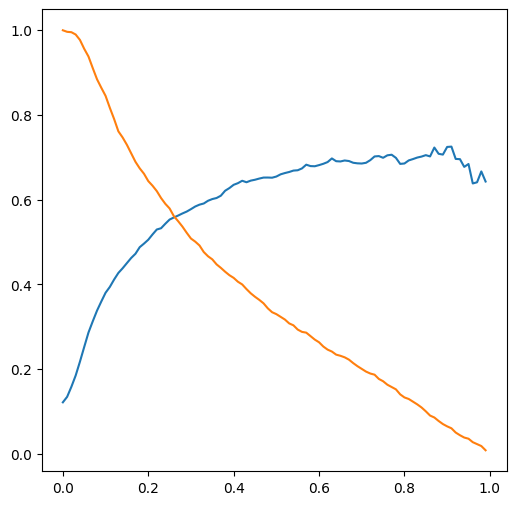

In [22]:
thresholds = np.arange(0.0, 1.0, 0.01)
precisions = []
recalls = []

for threshold in tqdm(thresholds):
    y_pred = (y_prob >= threshold).astype(int)

    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    precisions.append(precision)
    recalls.append(recall)

#print(f"Thresholds: {thresholds}")
#print(f"Precision: {precisions}")
#print(f"Recall: {recalls}")

# Plot precision and recall curves
plt.figure(figsize=(6, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [23]:
thresholds = np.arange(0.0, 1.0, 0.01)

In [24]:
def compute_f1_score(precision, recall):
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

f1_scores = {}

for threshold, precision, recall in zip(thresholds, precisions, recalls):
    f1 = compute_f1_score(precision, recall)
    f1_scores[threshold] = f1

# Get threshold where F1 is maximal
max_f1_threshold = max(f1_scores, key=f1_scores.get)
max_f1_score = f1_scores[max_f1_threshold]

print(f"Threshold where F1 is maximal: {max_f1_threshold}")
print(f"Maximal F1 score: {max_f1_score}")

Threshold where F1 is maximal: 0.22
Maximal F1 score: 0.5713087248322147


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [25]:
df_full_train

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
0,52,management,married,tertiary,0,no,cellular,22,aug,232,2,-1,0,unknown
1,50,admin.,single,secondary,330,yes,unknown,28,may,24,1,-1,0,unknown
2,45,blue-collar,married,primary,300,yes,cellular,29,jan,203,1,261,3,failure
3,38,technician,married,secondary,27,yes,unknown,3,jun,404,4,-1,0,unknown
4,31,services,single,secondary,887,no,cellular,30,jan,427,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,50,technician,married,tertiary,1830,no,cellular,14,may,318,3,-1,0,unknown
36164,34,management,divorced,tertiary,528,yes,cellular,17,apr,233,2,-1,0,unknown
36165,48,management,married,tertiary,4191,no,unknown,21,may,363,6,-1,0,unknown
36166,45,admin.,married,unknown,1783,no,unknown,20,jun,11,11,-1,0,unknown


In [26]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

AttributeError: 'DataFrame' object has no attribute 'churn'